## 1. Imports and Setup

Import all required libraries for data manipulation, model building, and training.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import json

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## 2. Data Preprocessing

Define transforms for data preprocessing and augmentation. These help improve model generalization.


In [3]:
# We resize the input images, convert them to tensors and normalize them to [-1,1]
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize images to 128x128
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Augmented transform
augmented_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 3. Data Loading and Train/Validation Split

Specify the dataset paths and load the image dataset using `ImageFolder`.


In [4]:
#if on Kaggle, use this
train_dir = '/kaggle/input/inaturalist/inaturalist_12K/train'
test_dir = '/kaggle/input/inaturalist/inaturalist_12K/val'

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)



In [5]:
# Load the full training dataset
full_train_dataset = ImageFolder(root=train_dir, transform=transform)

# Calculate split sizes
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the test set
test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [6]:
#Make sure every class is represented equally in validation data

from collections import Counter
import matplotlib.pyplot as plt

# Get original dataset labels (from the subset indices)
val_targets = [full_train_dataset.targets[i] for i in val_dataset.indices]

# Count frequency of each class
val_class_counts = Counter(val_targets)

print(sorted(val_class_counts.items()))

[(0, 204), (1, 191), (2, 219), (3, 191), (4, 207), (5, 203), (6, 204), (7, 202), (8, 195), (9, 183)]


## 4. Model Definition

Define the CNN architecture using PyTorch. The architecture can be configured via a list of convolutional filters.


In [7]:
num_classes = len(full_train_dataset.classes)

class CNN(nn.Module):
    def __init__(self, num_classes, conv_filters=[96, 256, 384, 384, 256], kernel_sizes=[3, 3, 3, 3, 3], activation_fn=F.relu, fc_units=[1024],dropout=[0.0],
        use_batchnorm=False):
        super(CNN, self).__init__()


        # Ensure the number of filters matches the number of kernel sizes
        assert len(conv_filters) == len(kernel_sizes), "conv_filters and kernel_sizes must be the same length"

        self.activation_fn = activation_fn   # Activation function to be used in conv layers
        self.use_batchnorm = use_batchnorm   # Whether to apply batch normalization

        self.pool = nn.MaxPool2d(2, 2)       # Max pooling layer with 2x2 kernel 


        self.conv_layers = nn.ModuleList()
        self.batchnorm_layers = nn.ModuleList()


        in_channels = 3    # Initial input has 3 channels (RGB)

        # Define convolutional layers
        for out_channels, kernel_size in zip(conv_filters, kernel_sizes):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2))

            # Optionally add batch normalization
            if use_batchnorm:
                self.batchnorm_layers.append(nn.BatchNorm2d(out_channels))

            in_channels = out_channels    # Update input channel size for next layer


        # Compute the size of the flattened feature map after conv + pool layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)   # Create dummy input of expected image size
            x = dummy_input
            for idx, conv in enumerate(self.conv_layers):
                x = conv(x)
                if self.use_batchnorm:
                    x = self.batchnorm_layers[idx](x)
                x = self.activation_fn(x)
                x = self.pool(x)
            self.flattened_size = x.view(1, -1).size(1)   # Compute the total number of features


        # Only one dense layer
        self.fc = nn.Linear(self.flattened_size, fc_units[0])
        self.dropout = nn.Dropout(dropout)

        # Final output layer
        self.fc_out = nn.Linear(fc_units[0], num_classes)

    def forward(self, x):
        # Pass through all convolutional layers
        for idx, conv in enumerate(self.conv_layers):
            x = conv(x)
            if self.use_batchnorm:
                x = self.batchnorm_layers[idx](x)
            x = self.activation_fn(x)
            x = self.pool(x)

        # Flatten the feature map to pass to fully connected layers
        x = torch.flatten(x, 1)

        # Pass through dense and dropout layers
        x = self.activation_fn(self.fc(x))
        x = self.dropout(x)
        x = self.fc_out(x)    # Output layer
        return x

## 5. Training Setup

Set up the device, activation function mapping.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CNN(num_classes, conv_filters=[64, 128, 256, 256, 128], kernel_sizes=[5, 3, 3, 3, 3], activation_fn=F.leaky_relu, fc_units=[512, 256]).to(device)

In [9]:
activation_map = {
    'relu': F.relu,
    'gelu': F.gelu,
    'silu': F.silu,
    'mish': F.mish
}

## 6. Training Function

Define the training loop that supports different configurations using WandB sweeps.


In [10]:
import wandb


In [11]:
def train(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config

        run.name = f"filters={config.conv_filters}_act={config.activation_fn}_aug={config.use_augmentation}_bn={config.use_batchnorm}_dropout={config.dropout}"
        run.save()

        # Choose transform for training
        if config.use_augmentation:
            train_transform = augmented_transform
        else:
            train_transform = transform

        # Load full dataset with chosen transform
        full_train_dataset = ImageFolder(train_dir, transform=train_transform)

        # Split into train and val
        val_size = int(0.2 * len(full_train_dataset))
        train_size = len(full_train_dataset) - val_size
        train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

        # Set val transform to basic (no augmentation)
        val_dataset.dataset.transform = transform

        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)


        # Model instantiation
        model = CNN(
                  num_classes=num_classes,
                  conv_filters=config.conv_filters,
                  kernel_sizes=[3] * len(config.conv_filters), #why 3?
                  activation_fn=activation_map[config.activation_fn],
                  fc_units=config.fc_units,
                  dropout=config.dropout,
                  use_batchnorm=config.use_batchnorm
              ).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)


        best_val_acc = 0.0

        #training loop
        for epoch in range(config.epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            #iterates over data batches
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()       #reset gradients
                outputs = model(inputs)     #forward pass
                loss = criterion(outputs, labels)
                loss.backward()           #backward pass
                optimizer.step()

                running_loss += loss.item()    #add loss
                _, predicted = torch.max(outputs.data, 1)    #get predicted classes
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()   #update count of correct preds

            # Compute training accuracy and average loss for the epoch
            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct_train / total_train

            # Validation phase
            model.eval()
            correct_val = 0
            total_val = 0

            # Disable gradient calculation for validation (saves memory and computations)
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    total_val += val_labels.size(0)
                    correct_val += (val_predicted == val_labels).sum().item()

            # Compute validation accuracy
            val_acc = 100 * correct_val / total_val
            model.train()

            #print results
            print(f"Epoch {epoch+1}/{config.epochs}")
            print(f"  Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}%")
            print(f"  Validation Accuracy: {val_acc:.2f}%\n")

            # Save best model and config
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")
                with open("best_config.json", "w") as f:
                    json.dump(dict(config), f)

            # Log metrics to W&B
            wandb.log({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_acc": val_acc
            })

 

## 7. Hyperparameter Sweep

Configure and launch a hyperparameter sweep using WandB.


In [12]:
# list out all the hyperparameter values to sweep through
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.001, 0.0005, 0.0001]
        },
        'epochs': {
            'values': [5,10]
        },
        'conv_filters': {
            'values': [
                [32, 64, 128, 256, 512],
                [64, 128, 256, 512, 1024],
                [32, 64, 64, 128, 128],
                [128, 128, 128, 128, 128],
                [1024,512,256,128,64],
                [512,256,128,64,32]
            ]
        },
        'activation_fn': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'fc_units': {
            'values': [[256],[512],[1024],]
        },
        'batch_size': {'values': [32, 64]},
        'use_batchnorm': {'values': [True, False]},
        'use_augmentation': {'values': [True, False]},
        'dropout': {'values': [0,0.1,0.2,0.3,0.5]}

    }
}


In [13]:
wandb.login(key='af7d7cf29d8954a13afb06c7a0d0c196c36ac51b')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
# Create sweep
sweep_id = wandb.sweep(sweep_config, project="inaturalist-hyperparam-tuning")

# Launch sweep agents
wandb.agent(sweep_id, function=train, count=10)  # runs 10 experiments

wandb.finish()


Create sweep with ID: fh69kdfx
Sweep URL: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/sweeps/fh69kdfx


wandb: Agent Starting Run: keebk14m with config:
wandb: 	activation_fn: mish
wandb: 	batch_size: 64
wandb: 	conv_filters: [32, 64, 64, 128, 128]
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	fc_units: [1024]
wandb: 	lr: 0.0005
wandb: 	use_augmentation: False
wandb: 	use_batchnorm: True
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch 1/10
  Training Loss: 2.0927 | Training Accuracy: 25.73%
  Validation Accuracy: 31.82%

Epoch 2/10
  Training Loss: 1.9049 | Training Accuracy: 32.24%
  Validation Accuracy: 31.47%

Epoch 3/10
  Training Loss: 1.8063 | Training Accuracy: 35.83%
  Validation Accuracy: 33.27%

Epoch 4/10
  Training Loss: 1.7064 | Training Accuracy: 39.21%
  Validation Accuracy: 35.62%

Epoch 5/10
  Training Loss: 1.5933 | Training Accuracy: 43.04%
  Validation Accuracy: 37.02%

Epoch 6/10
  Training Loss: 1.4735 | Training Accuracy: 47.79%
  Validation Accuracy: 38.12%

Epoch 7/10
  Training Loss: 1.3297 | Training Accuracy: 53.30%
  Validation Accuracy: 37.27%

Epoch 8/10
  Training Loss: 1.1812 | Training Accuracy: 58.35%
  Validation Accuracy: 37.42%

Epoch 9/10
  Training Loss: 0.9807 | Training Accuracy: 66.34%
  Validation Accuracy: 38.27%

Epoch 10/10
  Training Loss: 0.7620 | Training Accuracy: 74.85%
  Validation Accuracy: 39.32%



In [15]:
wandb.finish()

## 8. Best Model Evaluation

Evaluate the best performing model on the test dataset. The following configuration was observed to be the best performing model from the wandb sweep analysis.


In [26]:
best_config = {
    "conv_filters": [32, 64, 64, 128, 128],
    "fc_units": [256],
    "dropout": 0.5,
    "activation_fn": "mish",
    "use_batchnorm": True,
    "lr": 0.0005,
    "batch_size": 64,
    "epochs": 10,
    'use_augmentation' : True
}

Defining a new train function which returns the best model (with trained weights) as output so that we can test the performance on test data. This new train function also does not log anything into wandb.

In [28]:
def train(config):
    # Use passed config directly
    train_transform = augmented_transform if config['use_augmentation'] else transform
    full_train_dataset = ImageFolder(train_dir, transform=train_transform)
    val_size = int(0.2 * len(full_train_dataset))
    train_size = len(full_train_dataset) - val_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    val_dataset.dataset.transform = transform  # Ensure validation set uses basic transform

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

    # Model setup
    model = CNN(
        num_classes=num_classes,
        conv_filters=config["conv_filters"],
        kernel_sizes=[3] * len(config["conv_filters"]),
        activation_fn=activation_map[config["activation_fn"]],
        fc_units=config["fc_units"],
        dropout=config["dropout"],
        use_batchnorm=config["use_batchnorm"]
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                _, val_predicted = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()

        val_acc = 100 * correct_val / total_val
        model.train()

        # Print training progress
        print(f"Epoch {epoch+1}/{config['epochs']}")
        print(f"  Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}%")
        print(f"  Validation Accuracy: {val_acc:.2f}%\n")

    return model


Defining the trained model as the best model with trained weights

In [29]:
trained_model = train(best_config)  #best model after training


Epoch 1/10
  Training Loss: 2.1033 | Training Accuracy: 24.26%
  Validation Accuracy: 30.57%

Epoch 2/10
  Training Loss: 1.9662 | Training Accuracy: 30.29%
  Validation Accuracy: 28.31%

Epoch 3/10
  Training Loss: 1.8895 | Training Accuracy: 33.15%
  Validation Accuracy: 34.62%

Epoch 4/10
  Training Loss: 1.8226 | Training Accuracy: 35.45%
  Validation Accuracy: 35.62%

Epoch 5/10
  Training Loss: 1.7641 | Training Accuracy: 38.25%
  Validation Accuracy: 36.02%

Epoch 6/10
  Training Loss: 1.6755 | Training Accuracy: 41.12%
  Validation Accuracy: 37.72%

Epoch 7/10
  Training Loss: 1.6235 | Training Accuracy: 43.44%
  Validation Accuracy: 38.32%

Epoch 8/10
  Training Loss: 1.5494 | Training Accuracy: 45.14%
  Validation Accuracy: 38.17%

Epoch 9/10
  Training Loss: 1.4747 | Training Accuracy: 47.83%
  Validation Accuracy: 41.92%

Epoch 10/10
  Training Loss: 1.4036 | Training Accuracy: 52.12%
  Validation Accuracy: 39.37%



In [30]:
#Evaluating best model on test data
trained_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 42.25%


## 9. Model Visualization

Visualize predictions made by the model on test images.


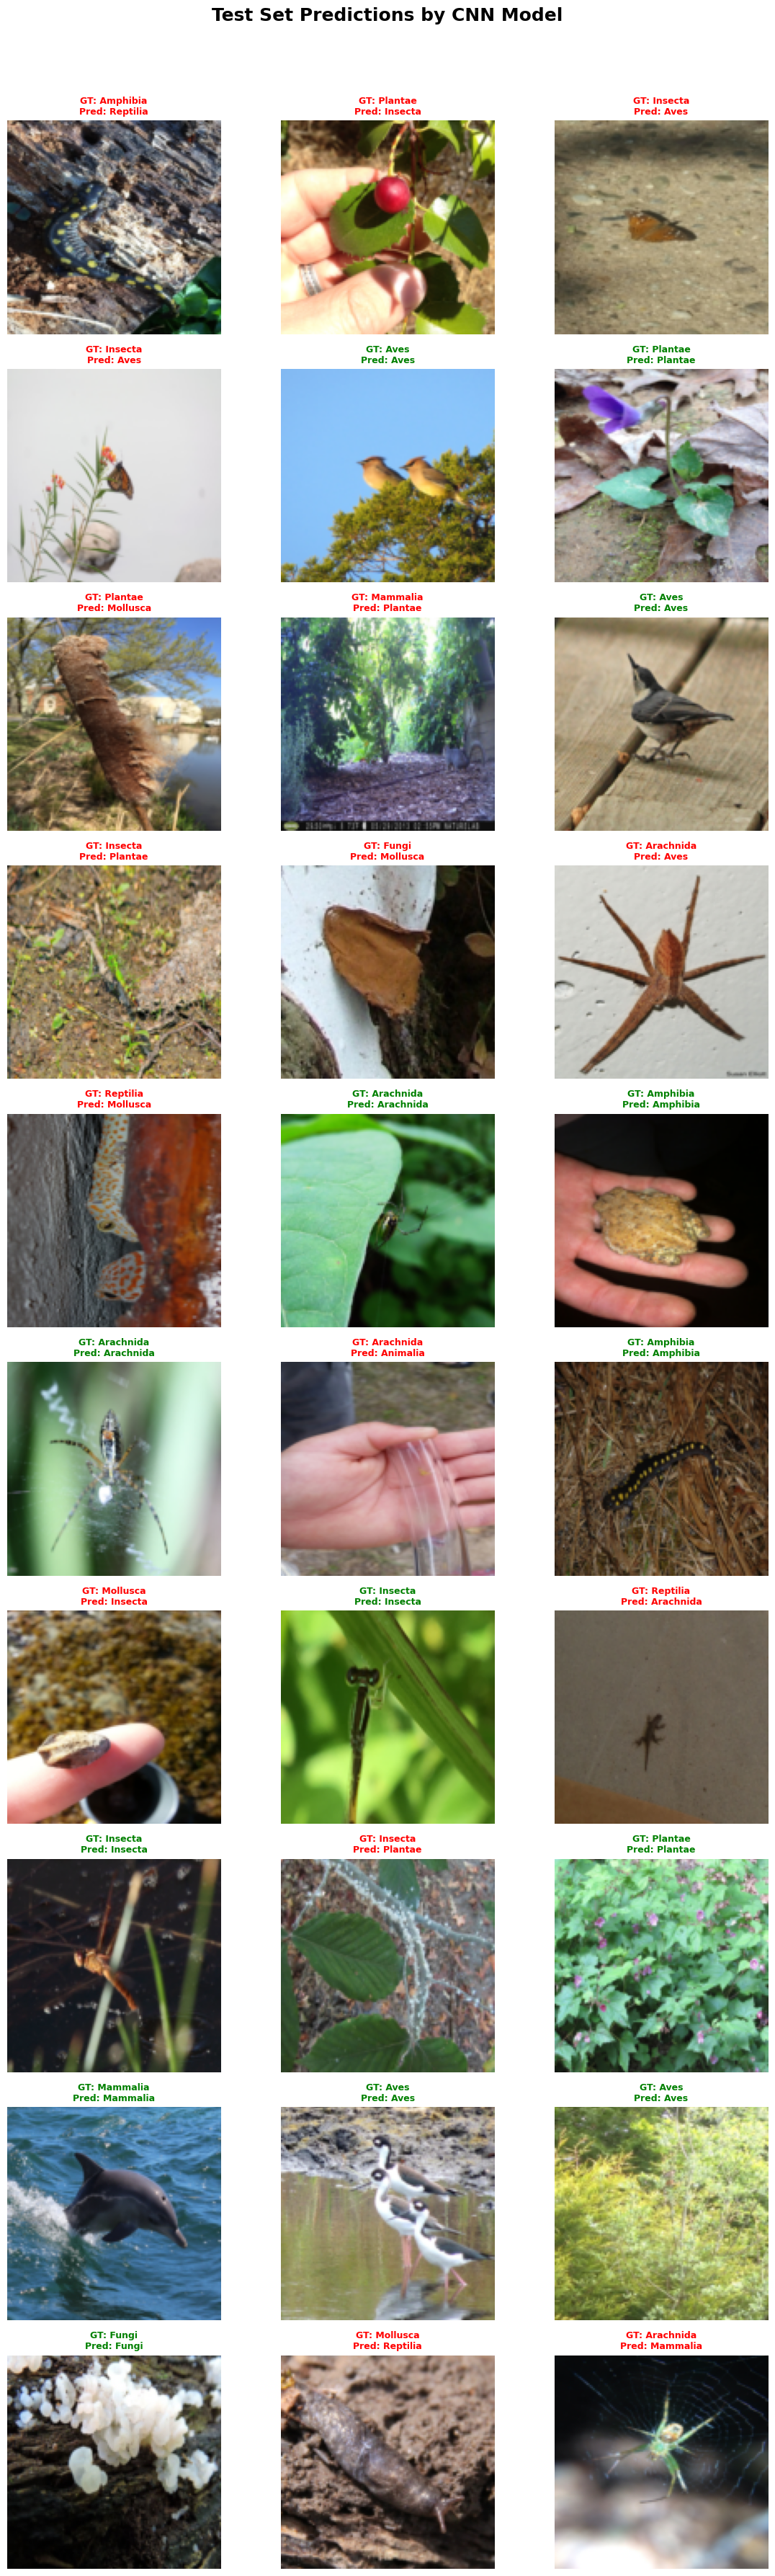

In [32]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random

# Ensure model is in evaluation mode
trained_model.eval()

# Un-normalize for display (adjust if you're using different normalization)
inv_transform = T.Compose([
    T.Normalize(mean=[0., 0., 0.], std=[1/0.5, 1/0.5, 1/0.5]),
    T.Normalize(mean=[-0.5, -0.5, -0.5], std=[1., 1., 1.])
])

# Mapping from label index to class name
class_names = full_train_dataset.classes

# Select 30 random samples from the test set
samples = random.sample(list(test_loader.dataset), 30)

# Create figure for predictions
fig, axes = plt.subplots(10, 3, figsize=(12, 35))
fig.suptitle("Test Set Predictions by CNN Model", fontsize=18, fontweight='bold', y=1.02)

for ax, (image, label) in zip(axes.flatten(), samples):
    image_tensor = image.unsqueeze(0).to(device)
    output = trained_model(image_tensor)
    _, pred = torch.max(output, 1)
    pred = pred.item()

    # Unnormalize and convert to numpy image
    img_disp = inv_transform(image).permute(1, 2, 0).cpu().numpy()
    img_disp = (img_disp * 255).clip(0, 255).astype("uint8")

    # Display image
    ax.imshow(img_disp)
    ax.axis("off")

    # Title shows ground truth and predicted label
    is_correct = (pred == label)
    title_color = 'green' if is_correct else 'red'
    ax.set_title(
        f"GT: {class_names[label]}\nPred: {class_names[pred]}",
        color=title_color,
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig("predictions_grid.png")

plt.show()
